In [2]:
import numpy as np
# import pandas as pd
import xarray as xr
# import zarr
# import xesmf as xe
import cartopy.crs as ccrs


In [3]:
# Grab some data 
!wget 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.EMC/.GEFSv12/.forecast/.pr/X/230/300/RANGEEDGES/Y/24/50/RANGEEDGES/S/(1%20Dec%202020)/RANGEEDGES/%5BS%5Daverage/M/0/5/RANGEEDGES/L/0.5/7.5/RANGEEDGES/data.nc'


--2021-01-11 15:59:20--  http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.EMC/.GEFSv12/.forecast/.pr/X/230/300/RANGEEDGES/Y/24/50/RANGEEDGES/S/(1%20Dec%202020)/RANGEEDGES/%5BS%5Daverage/M/0/5/RANGEEDGES/L/0.5/7.5/RANGEEDGES/data.nc
Resolving iridl.ldeo.columbia.edu (iridl.ldeo.columbia.edu)... 129.236.110.35
Connecting to iridl.ldeo.columbia.edu (iridl.ldeo.columbia.edu)|129.236.110.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 737788 (720K) [application/x-netcdf]
Saving to: ‘data.nc.1’

data.nc.1           100%[===================>] 720.50K  4.65MB/s    in 0.2s    

2021-01-11 15:59:23 (4.65 MB/s) - ‘data.nc.1’ saved [737788/737788]



In [4]:
# Load some data
data = xr.open_dataset('data.nc')
    

In [5]:
import cmocean
cmocean.cm.cmapnames


['thermal',
 'haline',
 'solar',
 'ice',
 'gray',
 'oxy',
 'deep',
 'dense',
 'algae',
 'matter',
 'turbid',
 'speed',
 'amp',
 'tempo',
 'rain',
 'phase',
 'topo',
 'balance',
 'delta',
 'curl',
 'diff',
 'tarn']

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


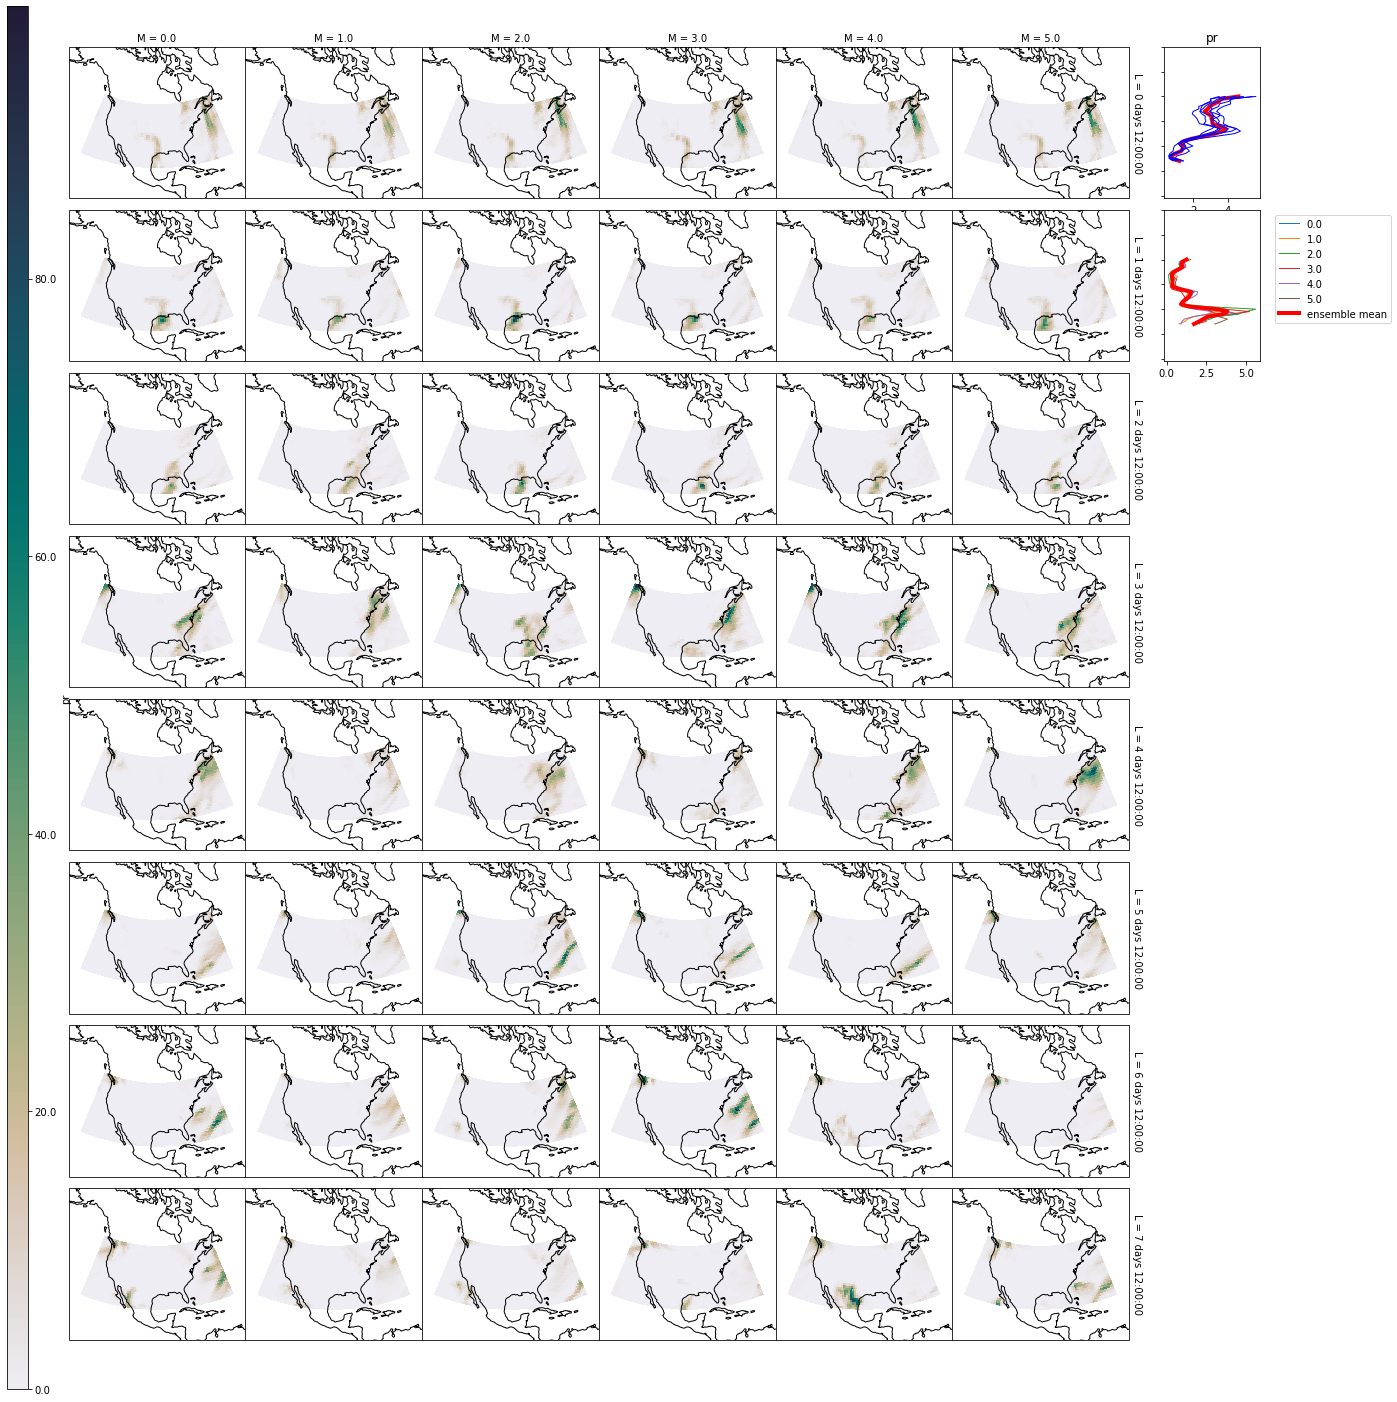

In [60]:
import matplotlib.pyplot as plt
cmap = cmocean.cm.rain

# this will set the extent of the map
ext = [230-360, 300-360, 9, 70]
# this is the projection of the plot, for the US this works well, for other area you want to change this
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)


# multiply pr to have mm/day units and not super small numbers
p = (data.pr*86400).plot(transform=ccrs.PlateCarree(),  # the data's projection - this is almost always PlateCaree... 
                 col='M', # dimension used for the column
                 row='L',  # dimension used for the row of the plot
#                 aspect=ds.dims['lon'] / ds.dims['lat'],  # for a sensible figsize - i don't think it's useful for facetgrid plots
                 subplot_kws={'projection': map_proj, }, # since you are plotting all those subplots together, 
                                                         # you need to tell which projection to use in transform kwarg for the subplots
                                                         # so you need this specific option only when you use this feature of xarray (i.e. col,row..)
                 cmap=cmap,# whatever cmap
                 add_colorbar=False, # do not create the colorbar now, you will create it after   
                                )  # the plot's projection

# Everything is stored now in "p" you can explore it if you want.

# We have to set the map's options on all axes, which are within "p"
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent(ext)

#I try to compact the figure as much as possible, it will never be 0 the space around figures
#because of the projections, but it helps.
plt.subplots_adjust(wspace=0, hspace=0)

# HERE I create a new ax where then I put the colorbar
# notice how i call the figure stored in "p" and then I add an axes to it
# the numbers are left bottom width height, so you have to play with it, they are relative to the whole figure. it can take a second..
cax = p.fig.add_axes([0.08, 0.1, 0.015, 0.8])
# add the colorbar to the figure "p" and i tell them which axes to use, cax.
p.add_colorbar(cax=cax, format='%.1f')



# Then if I want to add other plots (i.e. meridional means) you can just use the p.fig.add_axes trick again.
# you can either play with the numners in the square brackets until it places the axes where you want - 
# i.e. you might want to add an axes in a specific location. But as I want here, you want to match the extra axes 
# to the already present axes, then you can use .get_position().bounds for the axes.
# in my case I know that I have 6 columns, so I will get the second value (bottom) for position 0, 6, 12 and so on, 
# but you can automate this if you want.
bottom_values_from_top = [oa.get_position().bounds[1] for oa in p.axes.flat]
bottom_values_from_top = bottom_values_from_top[0::6]

#let's extract where I should put the new axes on the horizontal location
left_values = [oa.get_position().bounds[0] for oa in p.axes.flat]
left_values = left_values[0:6]
current_offset = left_values[1]-left_values[0]
# add some padding - this needs to be adjusted ad-hoc
current_offset += (0.2*current_offset)
new_axes_left_location = left_values[-1]+current_offset
# let's extract the height
height_values = [oa.get_position().bounds[-1] for oa in p.axes.flat]
height_values = height_values[0]
  
# of the plots i want to match my plot with, but i couldn't figure it out. 
ax1 = p.fig.add_axes([new_axes_left_location, bottom_values_from_top[0], 0.07, height_values])
# so let's do an average along the columns (over M) - mind I don't mask for ocean, but just to give an idea.
# I then avearage along lon, but I have to select one L at the time, because I am not using the "col" or "row" option
# I also tell xarray which dimension is the y axis
(data.pr*86400).mean('M').mean(dim='X').isel(L=0).drop('L').plot.line(y='Y', ax = ax1, add_legend=False, lw=4, color='r')
(data.pr*86400).mean(dim='X').isel(L=0).drop('L').plot.line(y='Y', ax = ax1, add_legend=False, lw=1, color='b')
#setting the extent of my plot, so that latitudes match with the map.
# I clean up the extra plot 
ax1.set_ylim(9, 70)
ax1.set_yticklabels('')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_title('pr')


# add another one and add a legend to that
ax1 = p.fig.add_axes([new_axes_left_location, bottom_values_from_top[1], 0.07, height_values])
# so let's do an average along the columns (over M) - mind I don't mask for ocean, but just to give an idea.
# I then avearage along lon, but I have to select one L at the time, because I am not using the "col" or "row" option
# I also tell xarray which dimension is the y axis
pp = (data.pr*86400).mean(dim='X').isel(L=1).drop('L').plot.line(y='Y', ax = ax1, add_legend=False, lw=1)
(data.pr*86400).mean('M').mean(dim='X').isel(L=1).drop('L').plot.line(y='Y', ax = ax1, add_legend=False, lw=4, color='r')
# I clean up the extra plot 
#setting the extent of my plot, so that latitudes match with the map, these are the values in the extent above
ax1.set_ylim(9, 70)
ax1.set_yticklabels('')
ax1.set_ylabel('')
ax1.set_xlabel('')
# this is to give the names to the legend and put the legend outside of the plot
# I create names to put in legend, if it had been one plot only (i.e. only the ensemble members) 
# I didn't need to create a list, and I could have passed data.M.values directly, but since I have to add 
# ensemble mean to the legend list, I have to create a list of values.
values_leg = [im for im in data.M.values]
values_leg.append('ensemble mean')
# bbox_to_anchor is relative to the axes, not the figure
ax1.legend(values_leg , bbox_to_anchor = (1.1, 1))

p.fig.set_rasterized(True)
# you need this "bbox_inches" whenever you use "bbox_to_anchor" in your legend, 
# otherwise the saving of the figure looses the legend
plt.savefig('aaa.png', bbox_inches='tight')


In [38]:
# below to show you how using get_position().bounds gets you the location of the axeses, in particular, 
# left, bottom, width and height - so it starts from the top row.
for oa in p.axes.flat:
    print(oa.get_position().bounds)

(0.125, 0.7890594211101685, 0.12916666666666665, 0.0875061577796632)
(0.25416666666666665, 0.7890594211101685, 0.1291666666666667, 0.0875061577796632)
(0.38333333333333336, 0.7890594211101685, 0.1291666666666667, 0.0875061577796632)
(0.5125000000000001, 0.7890594211101685, 0.12916666666666665, 0.0875061577796632)
(0.6416666666666667, 0.7890594211101685, 0.12916666666666665, 0.0875061577796632)
(0.7708333333333334, 0.7890594211101685, 0.12916666666666665, 0.0875061577796632)
(0.125, 0.6946844211101684, 0.12916666666666665, 0.0875061577796632)
(0.25416666666666665, 0.6946844211101684, 0.1291666666666667, 0.0875061577796632)
(0.38333333333333336, 0.6946844211101684, 0.1291666666666667, 0.0875061577796632)
(0.5125000000000001, 0.6946844211101684, 0.12916666666666665, 0.0875061577796632)
(0.6416666666666667, 0.6946844211101684, 0.12916666666666665, 0.0875061577796632)
(0.7708333333333334, 0.6946844211101684, 0.12916666666666665, 0.0875061577796632)
(0.125, 0.6003094211101685, 0.129166666666

In [41]:
oa.get_position().bounds[1]

0.1284344211101684

In [32]:
oaa = oa.get_position()

In [36]:
oaa.bounds

(0.125, 0.7890594211101685, 0.12916666666666665, 0.0875061577796632)